# 分类

## BCE loss
BCE (Binary Cross Entropy) 损失是用于二分类问题的损失函数，通常用于神经网络的二元分类任务中。

```python
BCE(y, y') = -[y * log(y') + (1 - y) * log(1 - y')]
```

In [65]:
import torch
import torch.nn as nn

# 创建 BCELoss
criterion = nn.BCELoss()

# 示例输入和目标（实际标签）
y = torch.tensor([1.0, 0.0, 1.0], requires_grad=True)  # 实际标签
y_pred = torch.tensor([0.9, 0.2, 0.8], requires_grad=True)  # 模型的预测概率值

# 计算 BCELoss ==> re = - (1 * math.log(0.9) + 1 * math.log(1 - 0.2) + 1*math.log(0.8)) / 3
loss = criterion(y_pred, y)

# 打印损失
print(loss)

tensor(0.1839, grad_fn=<BinaryCrossEntropyBackward0>)


## BCEWithLogitsLoss

二分类交叉熵损失函数的一种实现。它将 sigmoid 激活函数和二分类交叉熵损失合并在一起，通过单个函数实现了两者的计算。

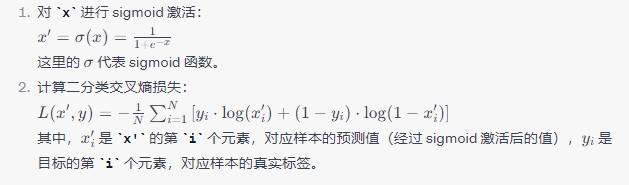

pos_weight 权重调整技巧：

二分类问题中，通常将目标类别称为正类别（Positive Class），将非目标类别称为负类别（Negative Class）。


在二分类问题中，通常情况下负类别（negative class）的样本数量远远大于正类别（positive class）的样本数量。这样一来，模型可能会更倾向于预测为负类别，因为这样可以降低整体的损失。

均衡数据集：如果数据集中正负样本的数量大致相等，可以将 pos_weight 设置为 1.0 或留空。

轻微不平衡：如果正负样本的数量稍微有些不平衡，可以尝试将 pos_weight 设置为介于 0.5 到 2.0 之间的值，以平衡正负样本的影响。

显著不平衡：如果正负样本的数量存在明显的不平衡，比如正样本远远少于负样本，可能需要将 pos_weight 设置为一个较大的值，比如 5.0 或更高，以便强调正样本的重要性。

In [67]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output.backward()

In [68]:
input

tensor([-0.0371,  0.5324,  0.1517], requires_grad=True)

In [69]:
target

tensor([1., 1., 0.])

In [70]:
output

tensor(0.6486, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [72]:
s1 = 1/(1 + math.exp(0.0371))
print(s1)

0.49072606370382016


In [73]:
s2 = 1/(1 + math.exp(-0.5324))
print(s2)

0.6300426996985233


In [74]:
s3 = 1/(1 + math.exp(-0.1517))
print(s3)

0.5378524366635301


In [75]:
total_loss = -(1*math.log(0.49072606370382016) + 1*math.log(0.6300426996985233) + (1-0)*math.log(1-0.5378524366635301)) / 3

In [77]:
total_loss

0.6485693147582109

## FocalLoss
Focal Loss 是一种用于解决类别不平衡问题的损失函数，特别适用于目标检测等任务。它通过减小易分类样本的权重，将模型的关注点放在困难样本上，从而提高了模型在困难样本上的性能。

示例：这段代码定义了一个名为FocalLoss的自定义PyTorch模块，它包装了一个现有的损失函数(loss_fcn)，并对原始损失函数的输出应用了Focal Loss修正。

这个 FocalLoss 模块可以用来替代任何现有的损失函数（只要它是兼容的，比如 nn.BCEWithLogitsLoss()）。它应用了 Focal Loss 以增强训练过程，特别是在类别不平衡的情况下。

设置经验：一般从2开始设置，上下0.5测试看效果。

当 gamma 较小（比如1）时，Focal Loss 对所有样本的影响相对均衡，相当于减弱了易分类样本的权重，强调了难分类样本的训练。

当 gamma 较大时，Focal Loss 对难样本的影响更大，容易分类的样本相对受到较小的影响。

In [78]:
class FocalLoss(nn.Module):
    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        super().__init__()
        self.loss_fcn = loss_fcn  # 必须是nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = 'none'  # 必须将reduction设置为'none'，以便对每个元素应用FL

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)

        # 计算 p_t（概率）
        pred_prob = torch.sigmoid(pred)  # 将对数几率转换为概率
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)

        # 计算 alpha 和 modulating 因子
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma

        # 应用 Focal Loss 修正
        loss *= alpha_factor * modulating_factor

        # 处理损失的缩减（reduction）
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss


## Cross Entropy Loss (交叉熵损失) 
是一个用于多类别分类问题的损失函数，通常用于神经网络训练中。

结合了 softmax 激活函数和交叉熵损失计算。

nn.CrossEntropyLoss() 会在内部应用 softmax 操作，因此在传递给损失函数时，你可以直接提供模型的原始输出，而不需要手动应用 softmax。


假设有 C 个类别，模型的输出为一个长度为 C 的向量 y_pred，实际标签为一个长度为 C 的 one-hot 编码向量 y_true，其中只有实际类别对应的位置为 1，其余位置为 0。

```python
CE(y_pred, y_true) = - Σ(y_true[i] * log(y_pred[i])) for i = 1 to C
```

**标签平滑的损失函数：nn.CrossEntropyLoss(label_smoothing=label_smoothing)**：

标签平滑是一种用于减缓过拟合的技术。它通过将目标标签向其他类别的概率分布进行平滑，来减少模型对训练数据的过度拟合。

传统的分类loss采用softmax loss，先对全连接层的输出计算softmax，视为各类别的置信度概率，再利用交叉熵计算损失。

现在假设一个多分类任务标签是[1,0,0]，如果它本身的label的出现了问题，这对模型的伤害是非常大的，因为在训练的过程中强行学习一个非本类的样本，并且让其概率非常高，这会影响对后验概率的估计。并且有时候类与类之间的并不是毫无关联，如果鼓励输出的概率间相差过大，这会导致一定程度上的过拟合。

一个较小的常数，这使得softmax损失中的概率优目标不再为1和0； 在一定程度上避免了过拟合，也缓解了错误标签带来的影响。

示例见下。

In [56]:
import torch
import torch.nn as nn

# 创建 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

criterion2 = nn.CrossEntropyLoss(label_smoothing=0.3)

# 示例输入和目标（实际标签）
y = torch.tensor([2, 0, 1], dtype=torch.long)  # 实际标签，每个值代表一个类别的索引
y_pred = torch.tensor([[0.1, 0.2, 0.9], [0.8, 0.3, 0.2], [0.2, 0.5, 0.3]])  # 模型的原始预测值，未经过 softmax

# 计算 CrossEntropyLoss
loss = criterion(y_pred, y)
loss2 = criterion2(y_pred, y)

# 打印损失
print(loss)
print(loss2)

tensor(0.7912)
tensor(0.8945)


In [57]:
import math
re = -(math.log(math.exp(0.9) / (math.exp(0.1) + math.exp(0.2) + math.exp(0.9))) + \
       math.log(math.exp(0.8) / (math.exp(0.8) + math.exp(0.3) + math.exp(0.2))) + \
       math.log(math.exp(0.5) / (math.exp(0.2) + math.exp(0.5) + math.exp(0.3))))/3

In [58]:
re

0.7911708456653378

In [61]:
# torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]])
# label_smoothing = 0.3 ==> torch.tensor([[0.1, 0.1., 0.7+0.1], [0.7+0.1, 0.1, 0.1], [0.1, 0.7+0.1, 0.1]])
# y_pred = torch.tensor([[0.1, 0.2, 0.9], [0.8, 0.3, 0.2], [0.2, 0.5, 0.3]])
re2 = -((0.1 * math.log(math.exp(0.1) / (math.exp(0.1) + math.exp(0.2) + math.exp(0.9)))) + \
        (0.1 * math.log(math.exp(0.2) / (math.exp(0.1) + math.exp(0.2) + math.exp(0.9)))) + \
        (0.8 * math.log(math.exp(0.9) / (math.exp(0.1) + math.exp(0.2) + math.exp(0.9)))) \
        + 0.8 * math.log(math.exp(0.8) / (math.exp(0.8) + math.exp(0.3) + math.exp(0.2))) + \
        0.1 * math.log(math.exp(0.3) / (math.exp(0.8) + math.exp(0.3) + math.exp(0.2))) + \
        0.1 * math.log(math.exp(0.2) / (math.exp(0.8) + math.exp(0.3) + math.exp(0.2)))\
        + 0.1 * math.log(math.exp(0.2) / (math.exp(0.2) + math.exp(0.5) + math.exp(0.3))) + \
        0.8 * math.log(math.exp(0.5) / (math.exp(0.2) + math.exp(0.5) + math.exp(0.3))) + \
        0.1 * math.log(math.exp(0.3) / (math.exp(0.2) + math.exp(0.5) + math.exp(0.3))) ) / 3

In [62]:
re2

0.8945041789986711

## softmax
Softmax 是一个常用的激活函数，通常用于多类别分类任务的神经网络中。它将一个实数向量（通常是神经网络的输出）变换成一个概率分布。

给定一个输入向量 x = [x1, x2, ..., xn]，Softmax 函数将每个元素 xi 转换成一个介于 0 到 1 之间的值，同时保证所有元素的和为 1。这种变换使得输出可以解释为属于各个类别的概率。

```python
softmax(xi) = exp(xi) / Σ(exp(xj)) for j = 1 to n
```

In [11]:
import torch
import torch.nn.functional as F

# 定义输入张量
x = torch.tensor([[0.1, 0.2, 0.9], [0.8, 0.3, 0.2], [0.2, 0.5, 0.3]])

# 计算 softmax
softmax_x = F.softmax(x, dim=1)

print(softmax_x)

tensor([[0.2309, 0.2552, 0.5139],
        [0.4640, 0.2814, 0.2546],
        [0.2894, 0.3907, 0.3199]])


In [12]:
import math
re1_1 = math.exp(0.1) / (math.exp(0.1) + math.exp(0.2) + math.exp(0.9))

In [13]:
re1_1

0.23090892108013442

##  Log-Softmax
在实际应用中，由于指数运算可能会导致数值稳定性问题，因此通常会使用改进版的 Softmax 函数，称为 Log-Softmax，其计算如下：

```python
log_softmax(xi) = xi - log(Σ(exp(xj))) for j = 1 to n
```

In [14]:
import torch
import torch.nn.functional as F

# 定义输入张量
x = torch.tensor([[0.1, 0.2, 0.9], [0.8, 0.3, 0.2], [0.2, 0.5, 0.3]])

# 计算 softmax ==>re1_1 = 0.1 - math.log(math.exp(0.1) + math.exp(0.2) + math.exp(0.9))
log_softmax_x = F.log_softmax(x, dim=1)

print(log_softmax_x)


tensor([[-1.4657, -1.3657, -0.6657],
        [-0.7679, -1.2679, -1.3679],
        [-1.2398, -0.9398, -1.1398]])


In [15]:
re1_1 = 0.1 - math.log(math.exp(0.1) + math.exp(0.2) + math.exp(0.9))

In [16]:
re1_1

-1.4657319272479288

## FLOPs
FLOPs 是浮点运算次数（Floating Point Operations），通常用于衡量深度学习模型的计算复杂度。

在深度学习中，每个神经网络层都包含一定数量的浮点运算，这些运算包括加法、乘法等。FLOPs用于表示一个模型执行的所有浮点运算的总数。

例如，如果一个模型在前向传播过程中总共执行了10亿次浮点运算，那么它的FLOPs数就是10亿（1e9）。 FLOPs数越高，模型的计算开销就越大，需要更多的计算资源来训练和推理。

## FLOPS
FLOPS（Floating Point Operations Per Second）是一个衡量计算机或计算设备性能的指标，它表示每秒钟可以执行的浮点运算次数。

如果一个模型的 FLOPs 为 1000，计算机的处理能力为 10 FLOPS，那么需要的最短计算时间为 100 秒（1000 / 10 = 100）。

FLOPS（Floating Point Operations Per Second）是一种计算机性能单位，用于表示每秒钟可以执行的浮点运算次数。它通常用于衡量计算机的处理速度和性能，特别是在科学计算、人工智能、大数据处理等领域。FLOPS的单位是每秒浮点运算次数，常用的前缀有k（千）、M（百万）、G（十亿）、T（万亿）等。

常见的英伟达显卡的FLOPS和显存规格：

```python
A100
FP32：19.5 TFLOPS
显存：80 GB

NVIDIA GeForce RTX 3090 Ti 
FP32: 36.45 TFLOPS
显存: 24 GB GDDR6X

NVIDIA GeForce RTX 3090
FP32: 35.7 TFLOPS
FP16: 285 TFLOPS

NVIDIA GeForce GTX 1080 Ti
FLOPS: 11.34 TFLOPS
显存: 11 GB GDDR5X

NVIDIA GeForce RTX 2080 Ti
FLOPS: 14.2 TFLOPS
显存: 11 GB GDDR6

NVIDIA Tesla V100
FLOPS: 7.5-15.7 TFLOPS (取决于精度)
显存: 16 GB HBM2

NVIDIA Tesla P100
FLOPS: 4.7-9.3 TFLOPS (取决于精度)
显存: 16 GB HBM2

NVIDIA Tesla T4
FLOPS: 8.1 TFLOPS
显存: 16 GB GDDR6

NVIDIA Quadro RTX 6000
FLOPS: 16.3 TFLOPS
显存: 24 GB GDDR6
```

## 参数量对应显存大小选型

假设我们已知模型的参数量为100M，最大推理batchsize为32，现在需要选定适合的推理芯片显存大小。下面是一个简单的计算过程：
首先，我们需要计算出模型在最大推理batchsize下所需要的显存大小。假设模型的输入数据大小为[h, w]，每个元素的数据类型为float32，那么模型每个batch的输入数据大小为[h, w, 32]（32为batchsize），占用显存大小为h * w * 32 * 4（4为float32的字节大小，即4个字节），同理，输出数据大小也为[h, w, 32]，占用显存大小也为h * w * 32 * 4，因此，模型在最大推理batchsize下所需要的显存大小为：

```pytoon
显存大小 = 输入数据大小 + 输出数据大小 + 模型参数大小
显存大小 = h * w * 32 * 4 + h * w * 32 * 4 + 100M * 4

```

这里假设模型所有参数都是float32类型，所以模型参数大小是100M * 4，如果模型参数类型不是float32，需要相应地调整计算。
假设我们希望显存利用率达到80%，则最终选定的显存大小为：

```python
显存大小 = (h * w * 32 * 4 + h * w * 32 * 4 + 100M * 4) / 0.8

```
一般一个参数是值一个float，也就是4个字节, 1kb=1024字节 。

pytorch中的floaps与显存计算方法:

```python
pip install thop
```

In [21]:
# -- coding: utf-8 --
import torch
import torchvision
from thop import profile

# Model
print('==> Building model..')
model = torchvision.models.alexnet(pretrained=False)

dummy_input = torch.randn(1, 3, 224, 224)
flops, params = profile(model, (dummy_input,))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1000000.0))


==> Building model..


/root/conda/envs/cv_env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/root/conda/envs/cv_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
flops:  714206912.0 params:  61100840.0
flops: 714.21 M, params: 61.10 M


## fuse_conv_and_bn
模型推理时，BN层要从训练状态切换到测试状态，此时采用模型训练中近似的均值和方差。BN层最酷的地方是它可以用一个1x1卷积等效替换，更进一步地，我们可以将BN层合并到前面的卷积层中。

https://zhuanlan.zhihu.com/p/110552861

https://nenadmarkus.com/p/fusing-batchnorm-and-conv/

## nn.SiLU()激活函数
SiLU 函数将输入 x 映射到一个介于 0 和 x 之间的范围内。与 ReLU 激活函数相比，SiLU 函数的输出范围更广，可以保留更多的信息。

```python
SiLU(x) = x * sigmoid(x)
```
sigmoid(x) 是 Sigmoid 函数，其数学表达式如下：
```python
sigmoid(x) = 1 / (1 + e^(-x))
```

## top1_acc 与 top5_acc
top1_acc 和 top5_acc 是评估模型性能的两个指标：

举例来说，如果模型对一张图像的预测结果是：[狗、猫、飞机、汽车、鱼]，而实际上这张图的标签是“猫”，那么：

Top-1 准确率为 0%（因为最高预测概率的类别不是“猫”）。

Top-5 准确率为 100%（因为“猫”在前五个预测类别中）。

在实际任务中，如果要求非常高的精确度，通常会关注 Top-1 准确率。但如果任务中类别众多，而且容忍模型的细微错误，可能会更关心 Top-5 准确率。

## EMA
通过采用指数衰减来维持变量的移动平均值。

    # EMA 指数移动平均 (Exponential Moving Average, EMA)。EMA 是一种平滑技术，它对模型参数进行平均，以减少训练期间的抖动和噪声。从而提高模型的稳定性和泛化性能。
    # 确保只有在本地或主节点（Rank为0）时才创建 EMA 模型，分布式训练时其他节点不会创建 EMA 模型。
    # ModelEMA 创建了一个指数移动平均模型，该模型会在训练过程中持续更新
    
在梯度下降的过程中，会一直维护着这个影子权重，但是这个影子权重并不会参与训练。基本的假设是，模型权重在最后的n步内，会在实际的最优点处抖动，所以我们取最后n步的平均，能使得模型更加的鲁棒。

https://zhuanlan.zhihu.com/p/68748778




# 目标检测

## 回调（callback）类, 回调函数的应用


在Python中，回调(callback)类和回调函数(callback function)是一种常用的编程模式，它们可以用于实现事件驱动的程序设计。回调函数是指在特定事件发生时，由系统自动调用的函数。

回调类通常用于以下情况：

事件处理: 当某个事件发生时，可以调用注册的回调函数来处理事件。

异步编程: 在异步编程中，回调是一种处理异步任务完成的方式，当异步任务完成时，系统会自动调用相应的回调函数。

定时任务: 可以使用回调函数来执行定时任务，例如在某个特定的时间点触发某个操作。

以下是一个简单的示例，演示了如何在Python中使用回调类和回调函数：

In [63]:
class EventManager:
    def __init__(self):
        self.callbacks = []

    def register_callback(self, callback):
        self.callbacks.append(callback)

    def trigger_event(self, event_data):
        for callback in self.callbacks:
            callback(event_data)

def on_event_fired(data):
    print(f"Event fired with data: {data}")

def another_callback(data):
    print(f"Another callback received data: {data}")

# 创建事件管理器实例
event_manager = EventManager()

# 注册回调函数
event_manager.register_callback(on_event_fired)
event_manager.register_callback(another_callback)

# 模拟触发事件
event_manager.trigger_event("Hello World")


Event fired with data: Hello World
Another callback received data: Hello World


## 超参数演化

超参数演化是一种优化算法，用于自动搜索机器学习模型的超参数（例如学习率、正则化项、批处理大小等），以找到最佳的超参数组合，从而提高模型的性能。 YOLOv5实现了一个基于遗传算法的超参数演化过程，用于搜索最优的超参数组合以提升模型性能。

遗传算法是利用种群搜索技术将种群作为一组问题解，通过对当前种群施加类似生物遗传环境因素的选择、交叉、变异等一系列的遗传操作来产生新一代的种群，并逐步使种群优化到包含近似最优解的状态，遗传算法调优能够求出优化问题的全局最优解，优化结果与初始条件无关，算法独立于求解域，具有较强的鲁棒性，适合于求解复杂的优化问题，应用较为广泛。



## 遗传算法
Hyperparameter evolution超参数演化是一种使用遗传算法（GA）进行优化的超参数优化方法。

https://github.com/ultralytics/yolov5/issues/607


https://blog.csdn.net/weixin_44751294/article/details/125163790


## 使用kmeans与遗传算法聚类anchor 
【目标检测trick，非yolov5中， yolov5中使用kmeans】

https://blog.csdn.net/weixin_44751294/article/details/124370382

## 自动混合精度训练（Automatic Mixed Precision，AMP）

自动混合精度训练（Automatic Mixed Precision，AMP）是一种用于加速深度学习模型训练的技术。它利用了现代GPU的混合精度计算能力，将模型中的一部分计算转换为低精度（例如半精度浮点数），从而减少了内存占用和计算量，加速了训练过程。

AMP的关键思想是将模型中的参数和梯度分为两个组：一个是需要高精度计算的部分，另一个是可以使用低精度计算的部分。通常情况下，模型的前向传播和反向传播过程中，大多数计算可以使用低精度进行，只有在参数更新时才需要高精度计算。

来支持 FP32 和 FP16 混合精度计算。也在 2018 年提出一个 PyTorch 拓展 apex，来支持模型参数自动混合精度训练。自动混合精度（Automatic Mixed Precision, AMP)训练，是在训练一个数值精度 FP32 的模型，一部分算子的操作时，数值精度为 FP16，其余算子的操作精度是 FP32，而具体哪些算子用 FP16，哪些用 FP32，不需要用户关心，amp 自动给它们都安排好了。这样在不改变模型、不降低模型训练精度的前提下，可以缩短训练时间，降低存储需求，因而能支持更多的 batch size、更大模型和尺寸更大的输入进行训练。

以下是AMP常用的一些优点：
```python
加速训练速度：通过减少计算量和内存占用，AMP可以显著加速模型的训练速度，尤其是在大型模型和大型数据集上。
减少内存占用：使用低精度计算可以减少模型参数和梯度的内存占用，使得可以训练更大的模型。
降低能源消耗：AMP可以降低训练过程中的计算资源消耗，从而节省能源。
提高模型性能：AMP训练过程中的数值误差通常是可以接受的，因此可以在保持模型性能的同时加速训练。
自动化管理：AMP提供了自动混合精度计算的机制，无需手动调整模型和优化器的配置。
```

## optimizer
https://zhuanlan.zhihu.com/p/482768895?utm_id=0

**SGD (随机梯度下降)**
全称：Stochastic Gradient Descent

简介：SGD 是最早也是最基本的优化算法之一。它通过在每次迭代中随机选择一小批样本来估计梯度，然后更新模型参数。这种随机性使得SGD能够跳出局部极小值，并且比一次性使用全部样本的批量梯度下降（BGD）更快地收敛。然而，由于其随机性，SGD在收敛到全局最小值时可能会出现一些震荡。

**Adam (自适应矩估计)**
全称：Adaptive Moment Estimation

简介：Adam是一种自适应学习率的优化算法。它维护了两个动量变量：一阶矩估计（关于梯度的指数移动平均）和二阶矩估计（关于梯度平方的指数移动平均）。这些估计值用于调整每个参数的学习率，使得在训练过程中逐渐降低学习率。Adam相对于SGD来说，通常具有更快的收敛速度。

**AdamW**

简介：AdamW 是对 Adam 算法的一种改进。它在 Adam 的基础上引入了权重衰减（Weight Decay）机制，用于防止模型参数变得过大。这可以提升模型的泛化性能。AdamW 在许多实际问题中表现出色。


## 损失函数

参考：
```python
    https://zhuanlan.zhihu.com/p/651170489
    https://zhuanlan.zhihu.com/p/415071583
    https://zhuanlan.zhihu.com/p/542157680
```

分类损失的损失函数：nn.BCEWithLogitsLoss

    二元交叉熵损失函数计算分类损失; 
    

目标损失的损失函数：nn.BCEWithLogitsLoss

    二元交叉熵损失
    
坐标框回归损失：CIOU loss 
    
    相对普通 IOU 优化不相交、相交、相对位置以及中心点位置一样这些特殊的不同框可能导致 IOU 相同的情况。

## 自适应图片缩放

原图大小：1080 x 1440

https://zhuanlan.zhihu.com/p/542157680

训练：640 x 640

训练时候没有采取缩减黑边的方式。

验证：512 x 672 

推理时缩减黑边，提高推理速度。使用矩形推理：设置参数 --rect 为 True，这将使用矩形推理策略，可以减小图像的大小以减少黑边区域，从而提高推理速度。

图像任务中，传入到模型的图像尺寸往往是固定，为什么？

    模型网络中含有全连接层的时候，输入尺寸只能固定大小，因为全连接网络的输入feature尺寸是固定的。一些模型网络就不一定需要尺寸固定，比如FCN网络中全是卷积网络而没有连接网络。
    yolov5比较特殊，输入图像宽高得是采样值32的倍数，这种特例就特别看待，也就是yolov5可以不固定，但是图像输入尺寸必须是32倍数，也是有一定限制。

## Focus层

Focus层原理。它采用切片操作把高分辨率的图片（特征图）拆分成多个低分辨率的图片/特征图，即隔列采样+拼接。原理图如下：
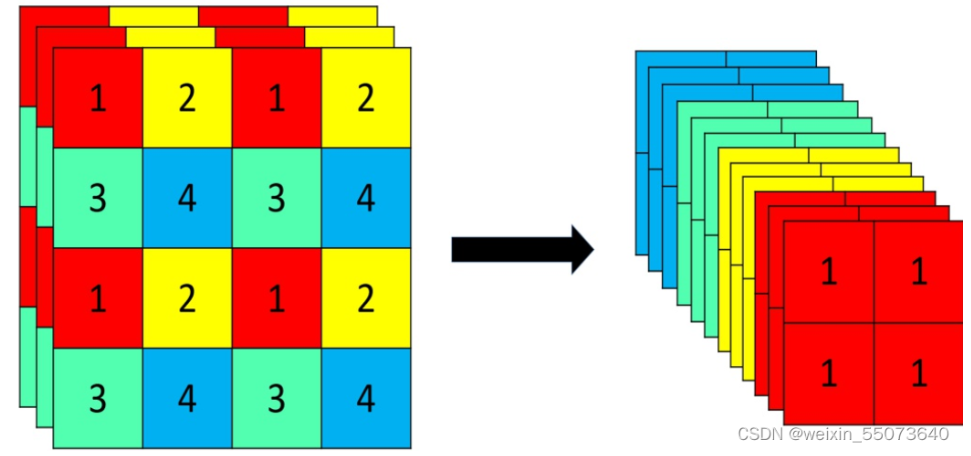

原始的640 × 640 × 3的图像输入Focus结构，采用切片（slice）操作，先变成320 × 320 × 12的特征图，拼接（Concat）后，再经过一次卷积（CBL(后期改为SiLU，即为CBS)）操作，最终变成320 × 320 × 64的特征图。

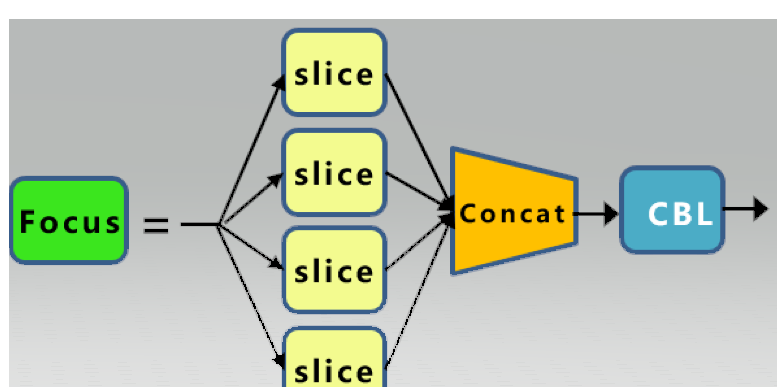

Focus层将w-h平面上的信息转换到通道维度，再通过3*3卷积的方式提取不同特征。采用这种方式可以减少下采样带来的信息损失。 增大感受野的同时降低运算量，如果没有前面的切片操作，直接接一个3乘3的卷积，那感受野肯定就小了一半啦，如果直接接一个6乘6的卷积，同样是输入3通道，输出32通道，那运算量会是前面的4倍。

最新代码取消了Focus操作, 直接以卷积取代:

https://blog.csdn.net/ogebgvictor/article/details/130477050

更换原因：

    在比较新的设备上，比如V100（虽然已经是上一代显卡了），30系显卡等（甚至还包括1080ti），conv比focus快，尤其是反向传播（cuda肯定也得用比较新的了）
    在比较老的显卡上比如k80、T4，conv比focus慢不少。
    本着优先考虑主流设备、新一代设备的原则，并且考虑到focus层对很多端侧设备不友好（比如ncnn就不支持focus层），所以作者就果断把它给换掉了。
    YOLOv5 Lite也在此之前也不约而同的选择了摘除Focus层，避免多次采用slice操作，对于的芯片，特别是不含GPU、NPU加速的芯片，频繁的slice操作只会让缓存占用严重，加重计算处理的负担。同时，在芯片部署的时候，Focus层的转化对新手极度不友好。
